In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import shutil
import random
import glob
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import itertools

In [3]:
os.chdir(r'C:\Users\Arjo\Desktop\DA and ML\KERAS\Sign_Language_Model')
if os.path.isdir('train/0/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0,10):
        shutil.move(f'{i}','train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'),30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}',f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'),5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}',f'test/{i}')   

os.chdir('../..')            

In [6]:
train_path=r'C:\Users\Arjo\Desktop\DA and ML\KERAS\Sign_Language_Model\train'
valid_path=r'C:\Users\Arjo\Desktop\DA and ML\KERAS\Sign_Language_Model\valid'
test_path=r'C:\Users\Arjo\Desktop\DA and ML\KERAS\Sign_Language_Model\test'

In [7]:
train_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), batch_size=10)
valid_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=10)
test_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


Modify the model

In [8]:
mobile=tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [9]:
#We don't want the last 4 layers
#We are going to fine tune the model
x=mobile.layers[-5].output
x = tf.keras.layers.Reshape(target_shape=(1024,))(x)
output=tf.keras.layers.Dense(10, activation='softmax')(x) #this means that to this output layer pass all of the layers that are passed to x

In [10]:
mobile.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [11]:
model=tf.keras.models.Model(inputs=mobile.input, outputs=output)

In [12]:
for layer in model.layers[:-23]:
    layer.trainable=False

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

Train the model

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
history=model.fit(x=train_batches, validation_data=valid_batches, epochs=30, verbose=2)

Epoch 1/30
172/172 - 80s - loss: 0.6574 - accuracy: 0.8119 - val_loss: 0.3663 - val_accuracy: 0.9100 - 80s/epoch - 467ms/step
Epoch 2/30
172/172 - 73s - loss: 0.1270 - accuracy: 0.9790 - val_loss: 0.1318 - val_accuracy: 0.9567 - 73s/epoch - 426ms/step
Epoch 3/30
172/172 - 74s - loss: 0.0560 - accuracy: 0.9936 - val_loss: 0.0722 - val_accuracy: 0.9867 - 74s/epoch - 431ms/step
Epoch 4/30
172/172 - 80s - loss: 0.0340 - accuracy: 0.9977 - val_loss: 0.0490 - val_accuracy: 0.9900 - 80s/epoch - 466ms/step
Epoch 5/30
172/172 - 74s - loss: 0.0235 - accuracy: 0.9988 - val_loss: 0.0519 - val_accuracy: 0.9900 - 74s/epoch - 427ms/step
Epoch 6/30
172/172 - 72s - loss: 0.0140 - accuracy: 1.0000 - val_loss: 0.0395 - val_accuracy: 0.9967 - 72s/epoch - 421ms/step
Epoch 7/30
172/172 - 72s - loss: 0.0186 - accuracy: 0.9982 - val_loss: 0.0624 - val_accuracy: 0.9800 - 72s/epoch - 420ms/step
Epoch 8/30
172/172 - 71s - loss: 0.0131 - accuracy: 0.9988 - val_loss: 0.0446 - val_accuracy: 0.9867 - 71s/epoch - 414

In [16]:
predictions=model.predict(test_batches, verbose=0)

In [17]:
np.argmax(predictions, axis=-1)

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8,
       8, 9, 9, 9, 9, 9], dtype=int64)

In [18]:
test_batches.classes

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8,
       8, 9, 9, 9, 9, 9])

In [19]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [20]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion Matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix without normalization")

    print(cm)

    thresh=cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],horizontalalignment="center", color="white" if cm[i,j]>thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')  

Confusion matrix without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


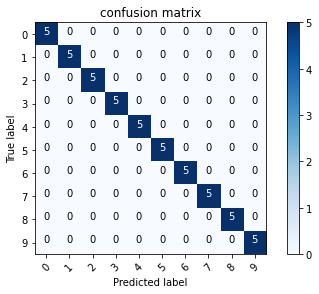

In [21]:
cm_plot_labels=['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='confusion matrix')

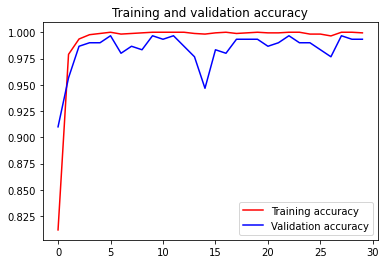

<Figure size 432x288 with 0 Axes>

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()